In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [75]:
def get_prices(round: int, day: int):

    path = f"../../data/round{round}/prices_round_{round}_day_{day}.csv"
    return pd.read_csv(path, sep=";")


def get_trades(round: int, day: int):

    path = f"../../data/round{round}/trades_round_{round}_day_{day}.csv"
    return pd.read_csv(path, sep=";")

price_frames = []
trade_frames = []

for day in range(-1, 0):  
#for day in range(0, 1):  
#for day in range(1, 2):  

    prices = get_prices(2, day)
    trades = get_trades(2, day)
    price_frames.append(prices)
    trade_frames.append(trades)

df = pd.concat(price_frames, ignore_index=True)
#all_trades = pd.concat(trade_frames, ignore_index=True)


In [77]:
df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,CROISSANTS,4304,112,NaN,NaN,NaN,NaN,4305,112,NaN,NaN,NaN,NaN,4304.5,0.0
1,-1,0,JAMS,6670,66,6669.0,137.0,NaN,NaN,6671,66,6672.0,137.0,NaN,NaN,6670.5,0.0
2,-1,0,SQUID_INK,2005,1,2002.0,31.0,NaN,NaN,2006,31,NaN,NaN,NaN,NaN,2005.5,0.0
3,-1,0,PICNIC_BASKET1,59284,20,59283.0,18.0,NaN,NaN,59294,2,59295.0,36.0,NaN,NaN,59289.0,0.0
4,-1,0,PICNIC_BASKET2,30606,20,30605.0,18.0,NaN,NaN,30612,20,30613.0,18.0,NaN,NaN,30609.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,-1,999900,DJEMBES,13493,76,NaN,NaN,NaN,NaN,13494,76,NaN,NaN,NaN,NaN,13493.5,0.0
79996,-1,999900,KELP,2028,31,NaN,NaN,NaN,NaN,2030,6,2031.0,31.0,NaN,NaN,2029.0,0.0
79997,-1,999900,RAINFOREST_RESIN,9992,32,NaN,NaN,NaN,NaN,10008,32,NaN,NaN,NaN,NaN,10000.0,0.0
79998,-1,999900,PICNIC_BASKET1,59222,2,59221.0,13.0,59220.0,27.0,59231,2,59232.0,13.0,59233.0,27.0,59226.5,0.0


In [79]:
def swmid(row):
    bid = row['bid_price_1']
    ask = row['ask_price_1']
    bid_volume = row['bid_volume_1']
    ask_volume = row['ask_volume_1']
    return ((bid*ask_volume + ask*bid_volume)/(bid_volume + ask_volume))

def mm_mid_basket(row, volume_cutoff=10):
    # Find the best bid with volume >= volume_cutoff
    for i in range(1, 4):
        if row[f'bid_volume_{i}'] >= volume_cutoff:
            best_bid = row[f'bid_price_{i}']
            break
    else:
        # No bid with sufficient volume found
        best_bid = None

    # Find the best ask with volume >= volume_cutoff
    for i in range(1, 4):
        if row[f'ask_volume_{i}'] >= volume_cutoff:
            best_ask = row[f'ask_price_{i}']
            break
    else:
        # No ask with sufficient volume found
        best_ask = None

    # Calculate the mid-price if both best bid and best ask are found
    if best_bid is not None and best_ask is not None:
        mid_price = (best_bid + best_ask) / 2
        return mid_price
    else:
        # Return the mid_price column value as default
        return row['mid_price']
    


def fair_price(row):
    if row['product'] == 'PICNIC_BASKET1' or row['product'] == 'PICNIC_BASKET2':
        return mm_mid_basket(row, volume_cutoff=10)
    else:
        return swmid(row)

df['fair'] = df.apply(fair_price, axis=1)



weights1 = {
    'CROISSANTS': 6,
    'JAMS': 3,
    'DJEMBES': 1
}
weights2 = {
    'CROISSANTS': 4,
    'JAMS': 2,
}

def compute_synthetic(group):
    def weighted_price(weights):
        bid = sum(
            group[group['product'] == p]['bid_price_1'].iloc[0] * w
            for p, w in weights.items()
            if p in group['product'].values
        )
        ask = sum(
            group[group['product'] == p]['ask_price_1'].iloc[0] * w
            for p, w in weights.items()
            if p in group['product'].values
        )
        return bid, ask

    syn1_bid, syn1_ask = weighted_price(weights1)
    syn2_bid, syn2_ask = weighted_price(weights2)

    return pd.Series({
        'synthetic1_bid': syn1_bid,
        'synthetic1_ask': syn1_ask,
        'synthetic2_bid': syn2_bid,
        'synthetic2_ask': syn2_ask,
    })

synthetic_df = df.groupby('timestamp', as_index=False).apply(compute_synthetic).reset_index(drop=True)

merged_df = pd.merge(df, synthetic_df, on='timestamp')

/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_70085/1503023935.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  synthetic_df = df.groupby('timestamp', as_index=False).apply(compute_synthetic).reset_index(drop=True)


In [80]:
# Get the unique product names
products = df['product'].unique()

# Create a new dataframe 'df_fairs' with the desired columns
columns = ['timestamp'] + list(products) + ['SYNTHETIC1', 'SYNTHETIC2']
df_fairs = pd.DataFrame(columns=columns)

# Iterate over unique timestamps in the original dataframe
for timestamp in df['timestamp'].unique():
    # Get the rows for the current timestamp
    rows = df[df['timestamp'] == timestamp]
    
    # Create a dictionary to store the fair values for each product
    fairs = {}
    
    # Iterate over each product and extract its fair value
    for product in products:
        fair = rows.loc[rows['product'] == product, 'fair'].values[0]
        fairs[product] = fair
    
    # Calculate the synthetic fair
    synthetic_fair1 = sum(fairs[product] * weights1.get(product, 0) for product in ['CROISSANTS','JAMS','DJEMBES'])
    synthetic_fair2 = sum(fairs[product] * weights2.get(product, 0) for product in ['CROISSANTS','JAMS'])
    
    new_row = {
        'timestamp': timestamp,
        **{product: fairs[product] for product in products},
        'SYNTHETIC1': synthetic_fair1,
        'SYNTHETIC2': synthetic_fair2
    }
    
    # Append the new row to df_fairs
    df_fairs = pd.concat([df_fairs, pd.DataFrame([new_row])], ignore_index=True)

# Reset the index of df_fairs (optional)
df_fairs = df_fairs.reset_index(drop=True)

/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_70085/2906553254.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_fairs = pd.concat([df_fairs, pd.DataFrame([new_row])], ignore_index=True)


In [81]:
df_fairs

,timestamp,CROISSANTS,JAMS,SQUID_INK,PICNIC_BASKET1,PICNIC_BASKET2,RAINFOREST_RESIN,DJEMBES,KELP,SYNTHETIC1,SYNTHETIC2
0,0,4304.500000,6670.5,2005.031250,59289.5,30609.0,10001.269231,13450.500000,2028.031250,59289.000000,30559.000000
1,100,4304.500000,6670.5,2005.500000,59287.5,30613.0,10000.000000,13450.000000,2027.769231,59288.500000,30559.000000
2,200,4304.500000,6671.0,2004.571429,59293.5,30615.0,10000.000000,13450.281690,2026.571429,59290.281690,30560.000000
3,300,4304.500000,6672.0,2004.500000,59293.5,30620.0,10000.000000,13450.000000,2027.818182,59293.000000,30562.000000
4,400,4305.500000,6672.0,2005.500000,59294.5,30622.0,10000.000000,13452.500000,2026.500000,59301.500000,30566.000000
...,...,...,...,...,...,...,...,...,...,...,...
9995,999500,4321.722727,6632.0,1971.454545,59226.5,30506.0,10001.285714,13493.000000,2029.454545,59319.336364,30550.890909
9996,999600,4321.500000,6632.0,1972.285714,59232.5,30506.5,10000.000000,13493.715686,2029.285714,59318.715686,30550.000000
9997,999700,4321.500000,6632.0,1972.500000,59227.0,30507.0,10000.000000,13493.500000,2030.000000,59318.500000,30550.000000
9998,999800,4321.768750,6632.0,1973.500000,59227.5,30506.0,10002.750000,13493.293333,2029.500000,59319.905833,30551.075000


In [82]:
df_fairs = df_fairs[['timestamp', 'CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1', 'SYNTHETIC1', 'PICNIC_BASKET2', 'SYNTHETIC2']]

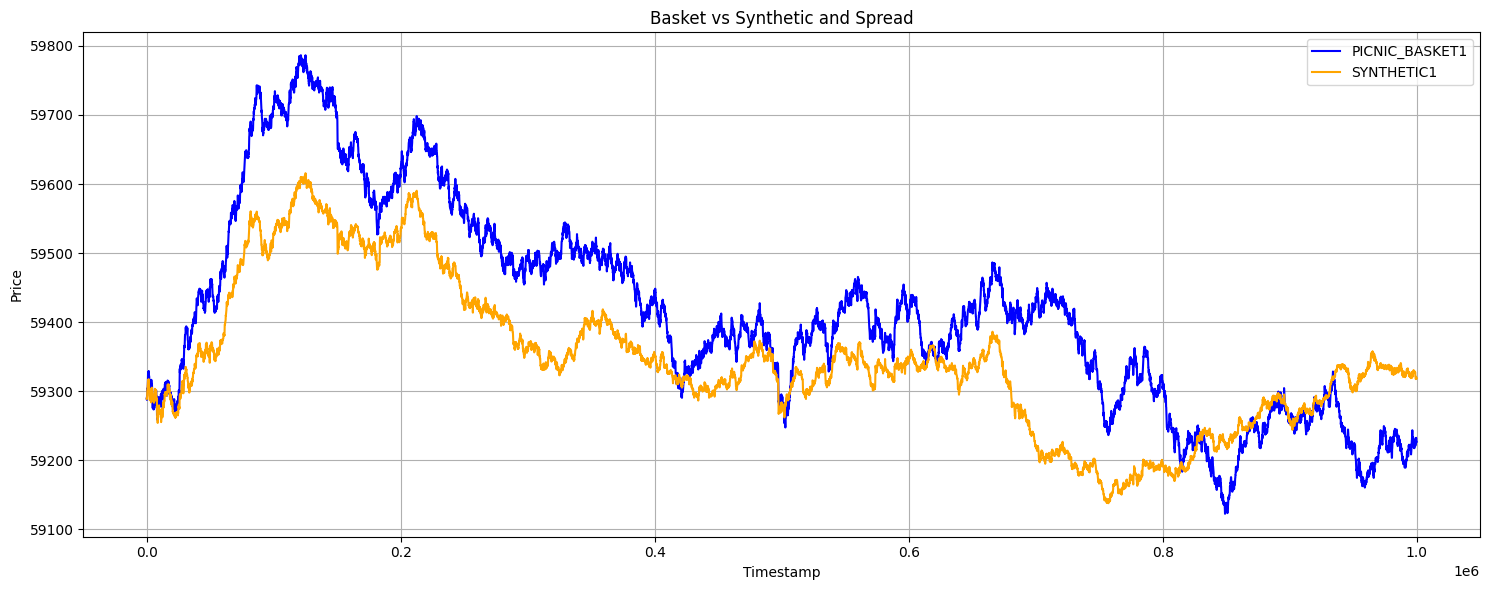

In [83]:
plt.figure(figsize=(15, 6))

plt.plot(df_fairs['timestamp'], df_fairs['PICNIC_BASKET1'], label='PICNIC_BASKET1', color='blue')
plt.plot(df_fairs['timestamp'], df_fairs['SYNTHETIC1'], label='SYNTHETIC1', color='orange')

plt.title('Basket vs Synthetic and Spread')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


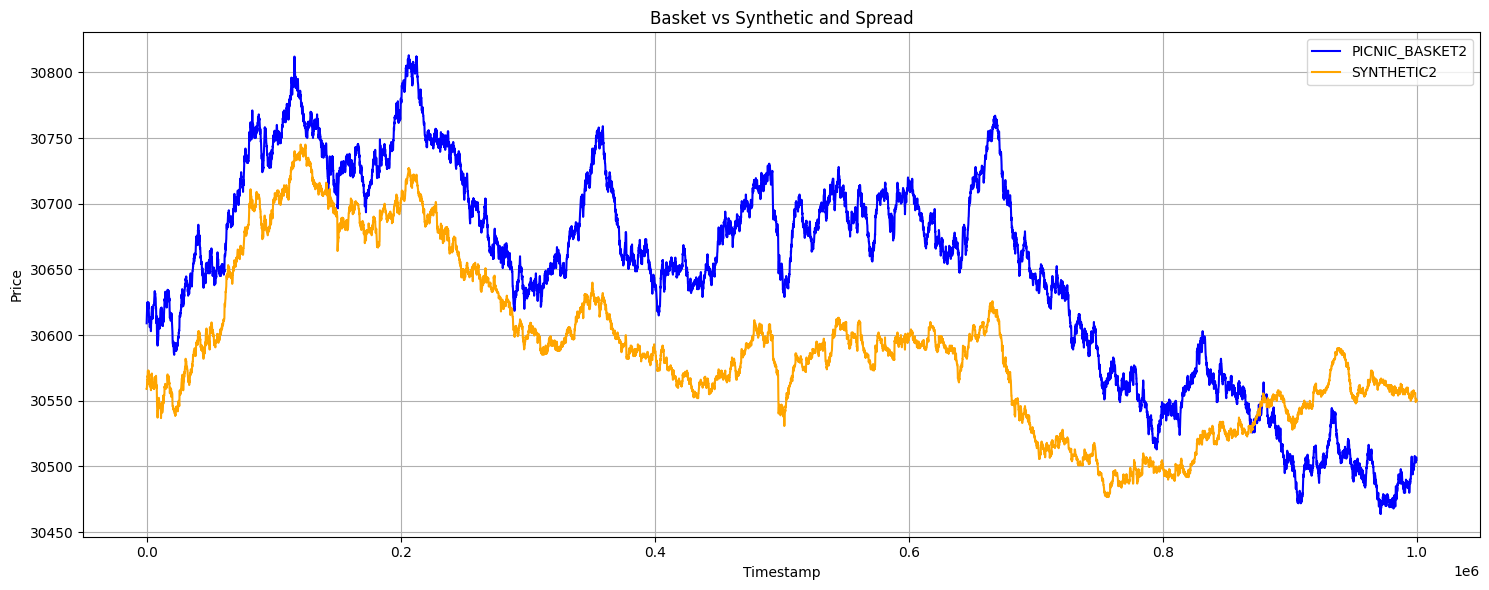

In [84]:
plt.figure(figsize=(15, 6))

plt.plot(df_fairs['timestamp'], df_fairs['PICNIC_BASKET2'], label='PICNIC_BASKET2', color='blue')
plt.plot(df_fairs['timestamp'], df_fairs['SYNTHETIC2'], label='SYNTHETIC2', color='orange')

plt.title('Basket vs Synthetic and Spread')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()